In [1]:
%matplotlib inline
import numpy as np
import firedrake
from firedrake import sqrt, exp, tanh
import hillslope

Set the dimensions of the domain and some physical constants.

In [2]:
Lx, Ly = 200, 200
k = 0.0035  # m^2/year
S = 1.25    # dimensionless
U = 7.5e-4  # m/year

Make a mesh and a space of continuous, piecewise-polynomial functions ('CG') of polynomial degree 2.

In [3]:
Nx, Ny = 48, 48
mesh = firedrake.RectangleMesh(Nx, Ny, Lx, Ly)
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)

Make the uplift rate peaked along a crescent shape.

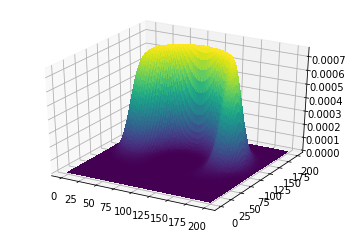

In [4]:
x, y = mesh.coordinates
R = 16
r = sqrt((x - Lx/2)**2 + (y - Ly/2)**2)
expression = exp(-(r/R - 4)**2) * (1 + tanh((y - Ly/2)/R))/2
u = firedrake.interpolate(U * expression, Q)
firedrake.trisurf(u)

Compute the steady state elevation profile.

In [5]:
zs = hillslope.steady_state(u)

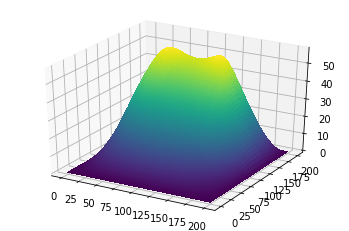

In [6]:
firedrake.trisurf(zs)

Calculate the value of the potential at the steady state.

In [7]:
from firedrake import inner, grad, dx, ln
J = -(k * S**2 / 2 * ln(1 - inner(grad(zs), grad(zs)) / S**2) + u * zs) * dx

print(firedrake.assemble(J))

-124.22703499181202


Given the critical slope, the size of the domain, and the uplift rate, calculate the time necessary to bring an initially flat profile up to the critical slope.

In [8]:
T = S * Lx / (2 * U)
print(T)

166666.66666666666


Solve the time-dependent problem starting from an initially flat landscape up to the characteristic time defined above.

In [9]:
z = firedrake.Function(Q)

In [10]:
from firedrake import inner, grad, dx, ln
J = -(k * S**2 / 2 * ln(1 - inner(grad(z), grad(z)) / S**2) + u * z) * dx

dt = 2e2
num_steps = int(T / dt)
Js = np.zeros(num_steps)

for step in range(num_steps):
    z.assign(hillslope.solve(dt, z, u))
    Js[step] = firedrake.assemble(J)

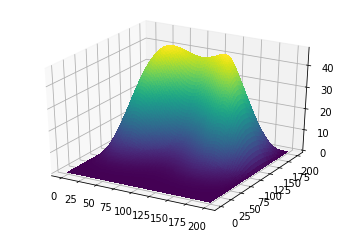

In [11]:
firedrake.trisurf(z)

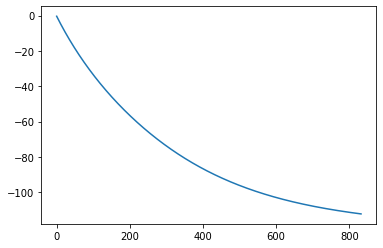

In [12]:
import matplotlib.pyplot as plt
plt.plot(Js)

The potential decreases, which we expect since hillslope transport is a gradient flow.